In [1]:
%matplotlib inline

import csv
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import sys
import datetime as dt
import pandas as pd

def read_sta(filename, pdt):
    
    print filename
    print pdt
    
    nc = netCDF4.Dataset(filename, 'r')
    station = len(nc.dimensions['station'])
    s_rho = len(nc.dimensions['s_rho'])
    h = nc.variables['h'][:]
    Cs_r = nc.variables['Cs_r'][:]
    ocean_time = nc.variables['ocean_time'][:]
    #time_units = nc.variables['ocean_time'].units
    time_units = 'seconds since 2012-06-01 00:00:00'
    
    print netCDF4.num2date(ocean_time[0], time_units),'-',netCDF4.num2date(ocean_time[-1], time_units)
    
    ptime = netCDF4.date2num(pdt, time_units)
    t = np.where(ocean_time == ptime)[0][0]
    
    print t
            
    zeta = nc.variables['zeta'][t,:]
    depth = np.ndarray(shape=[station,s_rho])
    for n in range(s_rho):
        for sta in range(station):
            depth[sta, n] = (h[sta]+zeta[sta]) * Cs_r[n]
    return nc, t, depth

def plot_sta(vname, station, nc, t, depth, ax, label):

    var = nc.variables[vname]
    if vname == 'phytoplankton':
        cff = 1.0/0.2515/2.18
    else:
        cff = 1.0
    if label == 'Free': line = '--'
    if label == 'Assi': line = '-'
    
    ax.plot(var[t,station-1,:]*cff, depth[station-1,:], line, c=c[vname], label=label)

    #ax.tick_params(labelleft='off')
    ax.set_ylim(-14,0)
    ax.set_title('Sta.{}, {}'.format(station, pdt.strftime('%Y-%m-%d %H:%M')))
    ax.grid()

In [2]:
def read_obs(obsfile, pdt):
    
    print obsfile
    print pdt
    
    nc = netCDF4.Dataset(obsfile, 'r')
    tunits = nc.variables['obs_time'].units
    ptime = netCDF4.date2num(pdt, tunits)
    print ptime
    
    obs_time = nc.variables['obs_time'][:]
    print netCDF4.num2date(obs_time[0], tunits),'-',netCDF4.num2date(obs_time[-1], tunits)
    
    t = np.where(obs_time == ptime)[0]
    obs_station = nc.variables['obs_station'][t[0]:t[-1]]
    obs_type = nc.variables['obs_type'][t[0]:t[-1]]
    obs_depth = nc.variables['obs_depth'][t[0]:t[-1]]
    obs_value = nc.variables['obs_value'][t[0]:t[-1]]
    
    df = pd.DataFrame(data={'station':obs_station, 'depth':obs_depth, 'type':obs_type, 'value':obs_value})
    return df

def plot_obs(vname, station, obs, ax):
    
    if vname == 'temp': vid = 6
    if vname == 'salt': vid = 7
    if vname == 'NO3': return
    if vname == 'zooplankton': return
    if vname == 'detritus': return
    if vname == 'phytoplankton':
        vid = 10
        cff = 1.0/0.2515/2.18
    else:
        cff = 1.0
    
    var = obs[obs.station == station]
    var = var[var.type == vid]
    ax.plot(var.value*cff, var.depth, 'o', mec='k', mfc='w',mew=1, label='Obs')

In [6]:
pdt = dt.datetime(2012,8,24,0)

free = '/Users/teruhisa/mpi00/fujii/non_wq/trunk_NL_20120608_5/osaka-bay_sta.nc'
free, ft, fdepth = read_sta(free, pdt)

/Users/teruhisa/mpi00/fujii/non_wq/trunk_NL_20120608_5/osaka-bay_sta.nc
2012-08-24 00:00:00
2012-06-01 00:00:00 - 2012-08-30 00:00:00
2016


In [4]:
assi = '/Users/teruhisa/mpi00/fujii/group_4dvar210_2/sta/osaka-bay_sta_024.nc'
assi, at, adepth = read_sta(assi, pdt)

/Users/teruhisa/mpi00/fujii/group_4dvar210_2/sta/osaka-bay_sta_024.nc
2012-08-24 00:00:00
2012-08-23 23:50:00 - 2012-08-24 00:50:00
1


In [5]:
obs = '/Users/teruhisa/hydcl00/okada/OB500/Data/ob500_obs_tsdc.nc'
obs = read_obs(obs, pdt)

/Users/teruhisa/hydcl00/okada/OB500/Data/ob500_obs_tsdc.nc
2012-08-24 00:00:00


RuntimeError: No such file or directory

(0, 2)

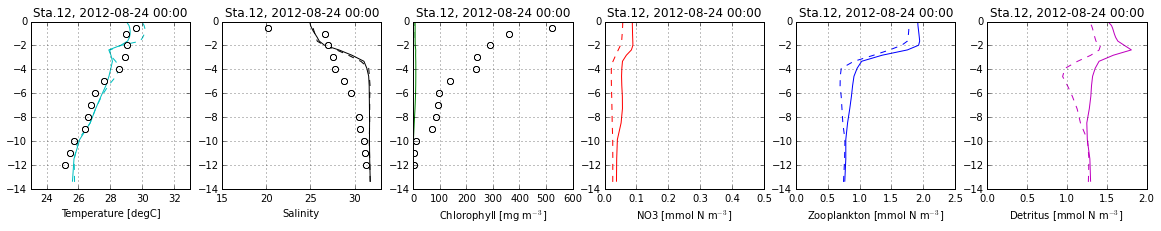

In [100]:
station = 12

vnames = ['temp', 'salt', 'phytoplankton', 'NO3', 'zooplankton', 'detritus']
    
c = {}
c['temp'] = 'c'
c['salt'] = 'k'
c['phytoplankton'] = 'g'
c['NO3'] = 'r'
c['zooplankton'] = 'b'
c['detritus'] = 'm'

fig, ax = plt.subplots(1, len(vnames), figsize=[20,3])
for i, vname in enumerate(vnames):
    plot_sta(vname, station, free, ft, fdepth, ax[i], 'Free')
    plot_sta(vname, station, assi, at, adepth, ax[i], 'Assi')
    plot_obs(vname, station, obs, ax[i])
    ax[i].grid()

ax[0].set_xlabel('Temperature [degC]')
ax[0].set_xlim(23,33)
ax[0].tick_params(labelleft='on')

ax[1].set_xlabel('Salinity')
ax[1].set_xlim(15,33)

ax[2].set_xlabel('Chlorophyll [mg m$^{-3}$]')
#ax[2].set_xlim(0,20)

mol = u' [mmol N m$^{-3}$]'
ax[3].set_xlabel('NO3'+mol)
ax[3].set_xlim(0,0.5)

ax[4].set_xlabel('Zooplankton'+mol)
ax[4].set_xlim(0,2.5)

ax[5].set_xlabel('Detritus'+mol)
ax[5].set_xlim(0,2)

In [101]:
strtime = pdt.strftime('%Y%m%d_%H%M')
fig.savefig('{}_{}.png'.format(strtime, station), bbox_inches='tight')